In [2]:
## モジュールの imports

import os, sys, re
import pprint as pp              # for use of pprint(..)
import random                    # for use of random.sample(..)
import numpy as np               # for efficient calculation
import matplotlib.pyplot as plt  # for plot
#from functools import reduce     # for use of reduce(..)

In [3]:
## コード実行の設定

verbose       = False
#run_LDA_tuner = False

### LDAのパラメター

## 生成源 = topic の個数の指定
n_topics = 10

### DTM 構築のパラメター

## 処理対象の指定: いずれも変更可能

## doc の設定
doc_size    = "sentence"
doc_type    = doc_size # doc_type がdoc_size と違う場合は明示的に定義

## 最短の文の長さ
min_doc_length = 3

## term の設定
term_size   = "word"
#term_types  = re.split(r",\s*", "1gram, skippy2gram, skippy3gram")
term_types  = [ '1gram', '2gram', 'skippy2gram', 'skippy3gram' ]
term_type   = term_types[2]

## n-grams の設定
ngram_is_inclusive = True # ngram が (n-1)gram を含むかどうか．True にしないとdoc が短い場合にエンコードされない

## skippy n-grams の設定
gap_mark =  ' … '
max_gap_val = 5

## min_freq = n の時，n 回以上使われている term のみを対象にする
min_freq = 2 # データ規模が小さい時には1でも良い

## abuse_threshold = n の時，全事例の100*n% に使われている term を対象にしない
## 多くの doc に帰属する term を除外するのに使う
abuse_threshold = 0.03

### tSNEのパラメター
## perplexiy は大き過ぎても，小さ過ぎてもいけないので，試行錯誤で良い値を探す．
## perplexity determinant r: 事例数のどれぐらいに設定するか．r が小さいと perplexity が小さい．
## 最適値は topic 数と相反するっぽい
doc_perplexity_is_relative = True
doc_perplexity_reduct_rate = 0.05

ファイル読み込み

In [4]:
### データの準備
import glob

## データのあるフォルダー名の指定 
targetdir = "txt_corporate profiles_2/"

## ファイル名の列挙
file_name_selector = "-sl.txt"
files = list(glob.glob(f"{targetdir}/*{file_name_selector}"))

## check file names
print(f"Directory '{targetdir}' contains {len(files)} files for candidates")
pp.pprint(files)

Directory 'txt_corporate profiles_2/' contains 75 files for candidates
['txt_corporate profiles_2/Corporate-profiles-by-MC-in-1998-sl.txt',
 'txt_corporate profiles_2/Corporate-profiles-by-NLI-in-1998-sl.txt',
 'txt_corporate profiles_2/Corporate-profiles-by-WFS2-in-1998-sl.txt',
 'txt_corporate profiles_2/Corporate-profiles-by-MK-in-1998-sl.txt',
 'txt_corporate profiles_2/Corporate-profiles-by-AIG-in-2005-sl.txt',
 'txt_corporate profiles_2/Corporate-profiles-by-CCM-in-2021-sl.txt',
 'txt_corporate profiles_2/Corporate-profiles-by-CN-in-1998-sl.txt',
 'txt_corporate profiles_2/Corporate-profiles-by-AS-in-1998-sl.txt',
 'txt_corporate profiles_2/Corporate-profiles-by-CCM-in-2005-sl.txt',
 'txt_corporate profiles_2/Corporate-profiles-by-BB-in-1998-sl.txt',
 'txt_corporate profiles_2/Corporate-profiles-by-OC-in-2021-sl.txt',
 'txt_corporate profiles_2/Corporate-profiles-by-MM-in-1998-sl.txt',
 'txt_corporate profiles_2/Corporate-profiles-by-VEC-in-2021-sl.txt',
 'txt_corporate profiles_

In [5]:
## 文章ごとに dictionary を構築 (ただし後で一つにまとめる)

var_names = re.split(r",\s+", "sentence, text, type, company, year")
vars = { x : None for x in var_names }
print(vars.items())

dict_items([('sentence', None), ('text', None), ('type', None), ('company', None), ('year', None)])


In [6]:
import re, os
import pandas as pd
import glob

# データの準備
targetdir = "txt_corporate profiles_2"  # 対象フォルダ
file_name_selector = "*.txt"  # すべてのtxtファイルを対象にします
files = list(glob.glob(f"{targetdir}/{file_name_selector}"))

# ファイルの内容を読み取り、情報をデータフレームに格納
ds = []
for i, file in enumerate(files):
    basename = os.path.basename(file)
    fields = re.split(r"-+", basename.replace(".txt", ""))
    if 'by' in fields and 'in' in fields:
        by_index = fields.index('by')
        in_index = fields.index('in')
        source_val = " ".join(fields[:by_index])
        
        # 'type' の抽出方法をここで定義する
        # ここでは 'by' と 'in' の間に 'type' が存在すると仮定
        type_val = " ".join(fields[by_index+1:in_index-1])  # 'type'を抽出
        
        company_val = " ".join(fields[in_index-1:in_index])
        year_val = fields[in_index+1]
        
        with open(file, encoding='utf8') as f:
            lines = [line.strip("\n") for line in f.readlines() if len(line.strip("\n")) > 0]
            d = pd.DataFrame(lines, columns=["sentence"])
            d["text"] = i + 1
            d["source"] = source_val
            d["type"] = type_val  # DataFrameに'type'列を加える
            d["company"] = company_val
            d["year"] = year_val
            ds.append(d)

# ファイルごとのデータの統合
df = pd.concat(ds, ignore_index=True)
print(df)


                                              sentence  text  \
0                                              Profile     1   
1    Merck & Co., Inc., is a global, research-drive...     1   
2                                        NEW YORK LIFE     2   
3    and its subsidiaries comprise the fifth larges...     2   
4    In addition to life insurance and annuity prod...     2   
..                                                 ...   ...   
518                            Create loyal customers?    74   
519                                                 4.    74   
520                         Deliver value and results?    74   
521         Prioritizing health at all stages of life.    75   
522                  Empowering generations of growth.    75   

                 source type company  year  
0    Corporate profiles           MC  1998  
1    Corporate profiles           MC  1998  
2    Corporate profiles          NLI  1998  
3    Corporate profiles          NLI  1998  
4    C

In [7]:
## ファイルごとのデータの統合
df = pd.concat(ds)
df

,sentence,text,source,type,company,year
0,Profile,1,Corporate profiles,,MC,1998
1,"Merck & Co., Inc., is a global, research-drive...",1,Corporate profiles,,MC,1998
0,NEW YORK LIFE,2,Corporate profiles,,NLI,1998
1,and its subsidiaries comprise the fifth larges...,2,Corporate profiles,,NLI,1998
2,In addition to life insurance and annuity prod...,2,Corporate profiles,,NLI,1998
...,...,...,...,...,...,...
5,Create loyal customers?,74,Corporate profiles,,AS,2005
6,4.,74,Corporate profiles,,AS,2005
7,Deliver value and results?,74,Corporate profiles,,AS,2005
0,Prioritizing health at all stages of life.,75,Corporate profiles,,CN,2021


In [8]:
df[df[doc_type] == None ]

,sentence,text,source,type,company,year


In [9]:
if verbose:
    list(df[doc_type])

In [10]:
print(df.columns)

Index(['sentence', 'text', 'source', 'type', 'company', 'year'], dtype='object')


In [11]:
# 例: 'type'ではなく、正しい列名が'topic_type'である場合
for var in [var for var in vars if var != doc_type]:
    print(df[var].value_counts(), end='\n\n')


text
46    25
70    23
51    23
47    21
34    21
      ..
23     1
33     1
36     1
61     1
67     1
Name: count, Length: 75, dtype: int64

type
    523
Name: count, dtype: int64

company
DC      47
UHG     39
MK      32
AS      30
PZ      30
NLI     29
CH      29
AE      27
CC      25
CN      20
WFS     20
CCM     18
CVS     17
VEC     17
CS      15
TD      15
MM      14
FM      12
CV      12
TD2     11
OC      11
BB      11
CC2     10
MC       7
DC2      6
AIG      6
WFS2     6
MM2      4
WM       3
Name: count, dtype: int64

year
1998    182
2021    172
2005    169
Name: count, dtype: int64



In [12]:
## 結果を確認
for var in [ var for var in vars if var != doc_type ]:
    print(df[var].value_counts(), end = '\n\n')

text
46    25
70    23
51    23
47    21
34    21
      ..
23     1
33     1
36     1
61     1
67     1
Name: count, Length: 75, dtype: int64

type
    523
Name: count, dtype: int64

company
DC      47
UHG     39
MK      32
AS      30
PZ      30
NLI     29
CH      29
AE      27
CC      25
CN      20
WFS     20
CCM     18
CVS     17
VEC     17
CS      15
TD      15
MM      14
FM      12
CV      12
TD2     11
OC      11
BB      11
CC2     10
MC       7
DC2      6
AIG      6
WFS2     6
MM2      4
WM       3
Name: count, dtype: int64

year
1998    182
2021    172
2005    169
Name: count, dtype: int64



文の語数でフィルター

In [13]:
## sentence の語数の列を追加
df['n_words'] = df[doc_type].apply(lambda x: len(re.split(r" +", x)))
df

,sentence,text,source,type,company,year,n_words
0,Profile,1,Corporate profiles,,MC,1998,1
1,"Merck & Co., Inc., is a global, research-drive...",1,Corporate profiles,,MC,1998,40
0,NEW YORK LIFE,2,Corporate profiles,,NLI,1998,3
1,and its subsidiaries comprise the fifth larges...,2,Corporate profiles,,NLI,1998,17
2,In addition to life insurance and annuity prod...,2,Corporate profiles,,NLI,1998,40
...,...,...,...,...,...,...,...
5,Create loyal customers?,74,Corporate profiles,,AS,2005,3
6,4.,74,Corporate profiles,,AS,2005,1
7,Deliver value and results?,74,Corporate profiles,,AS,2005,4
0,Prioritizing health at all stages of life.,75,Corporate profiles,,CN,2021,7


In [14]:
original_len = len(df)
df = df[df['n_words'] >= min_doc_length ]
print(f"{len(df)} rows; {original_len - len(df)} rows were discarded due to insufficient words")

452 rows; 71 rows were discarded due to insufficient words


各種 term の構築

In [15]:
### 単語 1-gram の列を追加

## 単語に分割し，小文字化
unigrams = [ re.split(r"[.,:;!?]*\s+", x.lower()) for x in df[doc_type] ]

## 単語の分割
unigrams = [ [ y.strip(".,:;!?") for y in x ] for x in unigrams ]

## 空語を除去
unigrams = [ [ y for y in x if len(y) > 0 ] for x in unigrams ]

##
if verbose:
    random.sample(unigrams, 10)

In [16]:
## stopwords の除去

## 定義
## 小文字に変換してあるので，大文字始まりの指定は必要ない

determiners = [ 'a', 'an', 'the', 'this', 'these', 'that', 'that\'s', 'those'  ]

pronouns = [ 'it', 'its', 'it\'s', 'they', 'them', 'their', 'theirs', 'theirs\'',
            'i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours', 'you', 'your', 'yours', 
           'she', 'she\'s', 'her', 'hers', 'he', 'he\'s', 'him', 'his' ]

prepositions = [ 'of', 'at', 'in', 'into', 'on', 'by', 'for', 'with', 'from', 'to' ]

auxiliaries = [ 'will', 'won\'t', 'would', 'wouldn\'t', 'can', 'can\'t',
               'could', 'couldn\'t', 'may', 'might', 'must' ]

light_verbs = [ 'do', 'don\'t', 'does', 'doesn\'t', 'did', 'didn\'t',
               'is', 'isn\'t', 'was', 'wasn\'t', 'are', 'aren\'t',
               'were', 'weren\'t', 'be', 'been', 'have', 'has', 'hasn\'t', 'had', 'hadn\'t',
              'i\'m', 'ain\'t', 'i\'ve', 'i\'d', 'you\'ve', 'you\'d', 'you\'re',
               'we\'re', 'we\'ve', 'we\'d', 'they\'re',
               'it\'s', 'he\'s', 'she\'s' ]

connectives = [ 'and', 'but', 'so', 'or' ]

companynames = [ 'optum', 'comapny','new york', '–', 'american', '- ', '•','&', 'cardinal','inc', 'corporation', 'wholesale', 'unitedhealthcare', 'united states''corporation','coca-cola', 'costco', 'unitedhealth', '記述なし', 'charter communications', 'new york life', 'new york life insurance company', 'merck & co', 'allstate insurance company', 'american express', 'express', 'pfizer', 'american international group', 'world fuel services', 'oracle', 'tech data', 'massachusetts mutual life insurance company', 'dow', 'best buy', 'the coca-cola company', 'cardinal health', 'cigna', 'costco wholesale corporation', 'cvs pharmacy', 'chevron corporation', 'ford motor company', 'mckesson corporation', 'unitedhealth group', 'valero']


## クラスの選択
ignored0 = determiners + pronouns + auxiliaries + light_verbs + prepositions + connectives + companynames
ignored1 = determiners + pronouns + light_verbs + prepositions + connectives + companynames
ignored2 = determiners + pronouns + prepositions + connectives + companynames
ignored3 = determiners + prepositions + connectives + companynames
ignored4 = determiners + connectives + companynames

## 実行
#　もともとFalse
ignore_stopwords = True
if ignore_stopwords:
    unigrams = [[ x for x in u if not x in ignored0 ] for u in unigrams ] # nesting is necessary

In [17]:
## 1gram 列の追加
df['1gram'] = unigrams
df

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74225/798635380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['1gram'] = unigrams


,sentence,text,source,type,company,year,n_words,1gram
1,"Merck & Co., Inc., is a global, research-drive...",1,Corporate profiles,,MC,1998,40,"[merck, co, global, research-driven, pharmaceu..."
0,NEW YORK LIFE,2,Corporate profiles,,NLI,1998,3,"[new, york, life]"
1,and its subsidiaries comprise the fifth larges...,2,Corporate profiles,,NLI,1998,17,"[subsidiaries, comprise, fifth, largest, life,..."
2,In addition to life insurance and annuity prod...,2,Corporate profiles,,NLI,1998,40,"[addition, life, insurance, annuity, products,..."
3,"Through its subsidiary, New York Life Internat...",2,Corporate profiles,,NLI,1998,19,"[through, subsidiary, new, york, life, interna..."
...,...,...,...,...,...,...,...,...
3,Keep our business growing?,74,Corporate profiles,,AS,2005,4,"[keep, business, growing]"
5,Create loyal customers?,74,Corporate profiles,,AS,2005,3,"[create, loyal, customers]"
7,Deliver value and results?,74,Corporate profiles,,AS,2005,4,"[deliver, value, results]"
0,Prioritizing health at all stages of life.,75,Corporate profiles,,CN,2021,7,"[prioritizing, health, all, stages, life]"


In [18]:
## 2gram 列の追加

bigrams = [ ]
for u in unigrams:
    b = [ ]
    for i in range(len(u)):
        try:
            b.append(" ".join([u[i], u[i+1]]))
        except IndexError:
            pass
    bigrams.append(b)
#
df['2gram'] = bigrams
df

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74225/1897908934.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['2gram'] = bigrams


,sentence,text,source,type,company,year,n_words,1gram,2gram
1,"Merck & Co., Inc., is a global, research-drive...",1,Corporate profiles,,MC,1998,40,"[merck, co, global, research-driven, pharmaceu...","[merck co, co global, global research-driven, ..."
0,NEW YORK LIFE,2,Corporate profiles,,NLI,1998,3,"[new, york, life]","[new york, york life]"
1,and its subsidiaries comprise the fifth larges...,2,Corporate profiles,,NLI,1998,17,"[subsidiaries, comprise, fifth, largest, life,...","[subsidiaries comprise, comprise fifth, fifth ..."
2,In addition to life insurance and annuity prod...,2,Corporate profiles,,NLI,1998,40,"[addition, life, insurance, annuity, products,...","[addition life, life insurance, insurance annu..."
3,"Through its subsidiary, New York Life Internat...",2,Corporate profiles,,NLI,1998,19,"[through, subsidiary, new, york, life, interna...","[through subsidiary, subsidiary new, new york,..."
...,...,...,...,...,...,...,...,...,...
3,Keep our business growing?,74,Corporate profiles,,AS,2005,4,"[keep, business, growing]","[keep business, business growing]"
5,Create loyal customers?,74,Corporate profiles,,AS,2005,3,"[create, loyal, customers]","[create loyal, loyal customers]"
7,Deliver value and results?,74,Corporate profiles,,AS,2005,4,"[deliver, value, results]","[deliver value, value results]"
0,Prioritizing health at all stages of life.,75,Corporate profiles,,CN,2021,7,"[prioritizing, health, all, stages, life]","[prioritizing health, health all, all stages, ..."


In [19]:
## 単語の不連続 2-gram の列を追加
## generate_skippy_ngrams.py の読み込みが必要

import ngrams_skippy
skippy_2grams = [ ngrams_skippy.generate_skippy_bigrams (u,
                                                         sep = " ",
                                                         max_distance = max_gap_val,
                                                         ignore_adjacency = False,
                                                         missing_mark = gap_mark) for u in df['1gram'] ]


## 包括的 2gram の定義
if ngram_is_inclusive:
    skippy_2grams = [ x + y for x, y in zip(skippy_2grams, unigrams) ]
#
if verbose:
    random.sample(skippy_2grams, 3)

In [20]:
df['skippy2gram'] = skippy_2grams
## 処理結果の確認
df

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74225/2478202564.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['skippy2gram'] = skippy_2grams


,sentence,text,source,type,company,year,n_words,1gram,2gram,skippy2gram
1,"Merck & Co., Inc., is a global, research-drive...",1,Corporate profiles,,MC,1998,40,"[merck, co, global, research-driven, pharmaceu...","[merck co, co global, global research-driven, ...","[merck co, merck … global, merck … research-dr..."
0,NEW YORK LIFE,2,Corporate profiles,,NLI,1998,3,"[new, york, life]","[new york, york life]","[new york, new … life, york life, new, york, l..."
1,and its subsidiaries comprise the fifth larges...,2,Corporate profiles,,NLI,1998,17,"[subsidiaries, comprise, fifth, largest, life,...","[subsidiaries comprise, comprise fifth, fifth ...","[subsidiaries comprise, subsidiaries … fifth, ..."
2,In addition to life insurance and annuity prod...,2,Corporate profiles,,NLI,1998,40,"[addition, life, insurance, annuity, products,...","[addition life, life insurance, insurance annu...","[addition life, addition … insurance, addition..."
3,"Through its subsidiary, New York Life Internat...",2,Corporate profiles,,NLI,1998,19,"[through, subsidiary, new, york, life, interna...","[through subsidiary, subsidiary new, new york,...","[through subsidiary, through … new, through … ..."
...,...,...,...,...,...,...,...,...,...,...
3,Keep our business growing?,74,Corporate profiles,,AS,2005,4,"[keep, business, growing]","[keep business, business growing]","[keep business, keep … growing, business growi..."
5,Create loyal customers?,74,Corporate profiles,,AS,2005,3,"[create, loyal, customers]","[create loyal, loyal customers]","[create loyal, create … customers, loyal custo..."
7,Deliver value and results?,74,Corporate profiles,,AS,2005,4,"[deliver, value, results]","[deliver value, value results]","[deliver value, deliver … results, value resul..."
0,Prioritizing health at all stages of life.,75,Corporate profiles,,CN,2021,7,"[prioritizing, health, all, stages, life]","[prioritizing health, health all, all stages, ...","[prioritizing health, prioritizing … all, prio..."


In [21]:
## 単語の不連続 3-gram の列を追加
## generate_skippy_ngrams.py の読み込みが必要

import ngrams_skippy

skippy_3grams = [ ngrams_skippy.generate_skippy_trigrams (u,
                                                         sep = " ",
                                                         max_distance = max_gap_val,
                                                         ignore_adjacency = False,
                                                         missing_mark = gap_mark) for u in df['1gram'] ]

## 包括的 3gram の生成
if ngram_is_inclusive:
    skippy_3grams = [ x + y for x, y in zip(skippy_3grams, skippy_2grams) ]

df['skippy3gram'] = skippy_3grams

## 処理結果の確認
df

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74225/2930848993.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['skippy3gram'] = skippy_3grams


,sentence,text,source,type,company,year,n_words,1gram,2gram,skippy2gram,skippy3gram
1,"Merck & Co., Inc., is a global, research-drive...",1,Corporate profiles,,MC,1998,40,"[merck, co, global, research-driven, pharmaceu...","[merck co, co global, global research-driven, ...","[merck co, merck … global, merck … research-dr...","[merck co global, merck co … research-driven, ..."
0,NEW YORK LIFE,2,Corporate profiles,,NLI,1998,3,"[new, york, life]","[new york, york life]","[new york, new … life, york life, new, york, l...","[new york life, new york, new … life, york lif..."
1,and its subsidiaries comprise the fifth larges...,2,Corporate profiles,,NLI,1998,17,"[subsidiaries, comprise, fifth, largest, life,...","[subsidiaries comprise, comprise fifth, fifth ...","[subsidiaries comprise, subsidiaries … fifth, ...","[subsidiaries comprise fifth, subsidiaries com..."
2,In addition to life insurance and annuity prod...,2,Corporate profiles,,NLI,1998,40,"[addition, life, insurance, annuity, products,...","[addition life, life insurance, insurance annu...","[addition life, addition … insurance, addition...","[addition life insurance, addition life … annu..."
3,"Through its subsidiary, New York Life Internat...",2,Corporate profiles,,NLI,1998,19,"[through, subsidiary, new, york, life, interna...","[through subsidiary, subsidiary new, new york,...","[through subsidiary, through … new, through … ...","[through subsidiary new, through subsidiary … ..."
...,...,...,...,...,...,...,...,...,...,...,...
3,Keep our business growing?,74,Corporate profiles,,AS,2005,4,"[keep, business, growing]","[keep business, business growing]","[keep business, keep … growing, business growi...","[keep business growing, keep business, keep … ..."
5,Create loyal customers?,74,Corporate profiles,,AS,2005,3,"[create, loyal, customers]","[create loyal, loyal customers]","[create loyal, create … customers, loyal custo...","[create loyal customers, create loyal, create ..."
7,Deliver value and results?,74,Corporate profiles,,AS,2005,4,"[deliver, value, results]","[deliver value, value results]","[deliver value, deliver … results, value resul...","[deliver value results, deliver value, deliver..."
0,Prioritizing health at all stages of life.,75,Corporate profiles,,CN,2021,7,"[prioritizing, health, all, stages, life]","[prioritizing health, health all, all stages, ...","[prioritizing health, prioritizing … all, prio...","[prioritizing health all, prioritizing health ..."


DTM の構築

In [22]:
## 必要ならgensim のインストール
#!pip install -U gensim

In [23]:
## LDA 構築の基になる dictionary = document-term matrix (dtm) を構築

from gensim.corpora.dictionary import Dictionary
diction = Dictionary(df[term_type])

## 結果の確認
print(diction)

## 多くの場合，濾過が必要

Dictionary<17025 unique tokens: ['animal', 'animal health', 'animal … directly', 'animal … joint', 'animal … products']...>


In [24]:
## diction の加工

import copy
diction_copy = copy.deepcopy(diction)

apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = min_freq, no_above = abuse_threshold)

## check
print(diction_copy)

Dictionary<1482 unique tokens: ['animal', 'animal health', 'animal … directly', 'animal … joint', 'animal … through']...>


In [25]:
##
diction = diction_copy
print(f"Number of unique tokens=terms: {len(diction)}")

## Corpus (= dtm) を構築
## doc は bag-of-terms 形式になっている必要がある
corpus = [ diction.doc2bow(doc) for doc in df[term_type] ]
print(f"Number of documents: {len(corpus)}")

Number of unique tokens=terms: 1482
Number of documents: 452


In [26]:
## Python 内の解析

In [27]:
## LDA モデルの構築
from gensim.models import LdaModel

## D の LDAモデル
d_lda = LdaModel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
#
print(d_lda)

LdaModel<num_terms=1482, num_topics=10, decay=0.5, chunksize=2000>


In [28]:
## inspect the first topic
d_lda.show_topic(0)

[('development', 0.008234174),
 ('pharmacy', 0.007532006),
 ('pharmaceutical', 0.006785667),
 ('build', 0.00655845),
 ('create', 0.006558267),
 ('manufacturing', 0.006138514),
 ('supply', 0.005896741),
 ('sales', 0.0058824825),
 ('improve', 0.0057500405),
 ('quality', 0.0056333123)]

In [29]:
%%capture --no-display

## D のtopic ごとに，関連度の高い term を表示

import pandas as pd

n_terms = 20 # topic ごとに表示するterm 数の指定
dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in d_lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #f'topic {topic+1}'だと1から始まりになる
    dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topics = pd.concat(dfs)

## Table で表示
topics.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10
0,development,such,provide,return,million,use,energy,fuel,including,each
1,pharmacy,such as,individuals,needs,retirement,affordable,focus,travel,annuities,locations)
2,pharmaceutical,consumer,technology,each,innovative,easy,pharmaceutical,fuel services,market,business partners
3,build,500,help,investment,vision,personal,innovative,marine,data,life insurance
4,create,network,provide … products,-,highest,investment,human,aviation,delivering,drug
5,manufacturing,providers,about,providing,work,strategic,provide,best,life insurance,2005
6,supply,deliver,infrastructure,investors,locations,embrace,employers,network,also,million
7,sales,corporate,million,structure,pharmacy,carbon,growing,values,thing,specialty
8,improve,superior,more … million,also,locations),employee,organization,most,subsidiaries,as … company
9,quality,best,than … million,provides,programs,internet,service,offers,distribution,chain


pyLDAvis の実行

In [30]:
%%capture --no-display

## pyLDAvis を使った結果の可視化: 階層クラスタリングより詳しい

import gensim
import pyLDAvis
from sklearn.manifold import TSNE as tsne

installed_version = gensim.__version__
print(f"installed gensim version: {installed_version}")

import sys
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis

pyLDAvis.enable_notebook()
#
use_MMDS = False
use_tSNE = False
if use_tSNE:
    vis = gensimvis.prepare(d_lda, corpus, diction, n_jobs = 1, sort_topics = False, mds = 'mmds')
elif use_tSNE:
    vis = gensimvis.prepare(d_lda, corpus, diction, n_jobs = 1, sort_topics = False, mds = 'tsne')
else:
    vis = gensimvis.prepare(d_lda, corpus, diction, n_jobs = 1, sort_topics = False)

#
pyLDAvis.display(vis)

Coherence の計算

In [31]:
from gensim.models import CoherenceModel

# 仮定: d_lda はLDAモデル、corpusはドキュメントのコーパス、dictionは辞書
# これらの変数は上のコードブロックで定義されているものと仮定します。

# Coherenceモデルを用いてcoherence scoreを計算
coherence_model_lda = CoherenceModel(model=d_lda, texts=df[term_type], dictionary=diction, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

coherence_lda

0.5660921934911515

Sentiment Analysis

In [32]:
import pandas as pd
from textblob import TextBlob
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
import numpy as np

# トピックの数を定義
n_topics = 10  # ここでの値はあなたのモデルに合わせて適宜変更してください


# DataFrameを作成または既存のDataFrameを使用します
# df = pd.DataFrame(...) あるいは既存のdfを使用

# ここでは、既に定義されているd_ldaとcorpusを使用します
# d_lda = LdaModel(...) と corpus = [...]

# トピックごとのセンチメント分析結果を格納するためのリスト
topic_sentiments = []

for topic_id in range(n_topics):
    # 各トピックに関連するドキュメントのセンチメントスコアを保存するリスト
    topic_polarity = []
    topic_subjectivity = []
    
    # 各トピックに最も関連するドキュメントのインデックスを特定
    doc_indices = [i for i, doc in enumerate(corpus) if sorted(d_lda[doc], key=lambda x: -x[1])[0][0] == topic_id]
    
    # 特定されたインデックスに基づいて文書のセンチメントを分析
    for i in doc_indices:
        # ドキュメントのテキストを取得
        doc_text = df.iloc[i]['sentence']
        # テキストからセンチメントスコアを計算
        sentiment = TextBlob(doc_text).sentiment
        topic_polarity.append(sentiment.polarity)
        topic_subjectivity.append(sentiment.subjectivity)
    
    # ポラリティと主観性の平均値を計算
    avg_polarity = np.mean(topic_polarity) if topic_polarity else 0
    avg_subjectivity = np.mean(topic_subjectivity) if topic_subjectivity else 0
    
    # 結果をリストに追加
    topic_sentiments.append({
        'topic_id': topic_id,
        'polarity_mean': avg_polarity,
        'subjectivity_mean': avg_subjectivity
    })

# 結果をDataFrameに変換
sentiments_df = pd.DataFrame(topic_sentiments)

# 結果の表示
print(sentiments_df)

   topic_id  polarity_mean  subjectivity_mean
0         0       0.147707           0.255046
1         1       0.146075           0.232322
2         2       0.139156           0.297667
3         3       0.116812           0.258876
4         4       0.169650           0.315368
5         5       0.121770           0.276983
6         6       0.141624           0.282988
7         7       0.177924           0.221176
8         8       0.094957           0.220555
9         9       0.128826           0.255637


In [33]:
# 各ドキュメントの主要トピックとその確率を識別
df.loc[:,'main_topic'] = [sorted(doc, key=lambda x: x[1], reverse=True)[0][0] for doc in d_lda.get_document_topics(corpus)]
df.loc[:,'topic_prob'] = [sorted(doc, key=lambda x: x[1], reverse=True)[0][1] for doc in d_lda.get_document_topics(corpus)]


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74225/158289219.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'main_topic'] = [sorted(doc, key=lambda x: x[1], reverse=True)[0][0] for doc in d_lda.get_document_topics(corpus)]
/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74225/158289219.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'topic_prob'] = [sorted(doc, key=lambda x: x[1], reverse=True)[0][1] for doc in d_lda.get_document_topics(corpus)]


In [34]:
# 年別に主要トピックの分布を集計
topic_distribution_by_year = df.groupby(['year', 'main_topic']).size().unstack(fill_value=0)

# 結果の表示
print(topic_distribution_by_year)


main_topic   0   1   2   3   4   5   6   7   8   9
year                                              
1998        13  25  11  20  18  16  15  15  16  10
2005        20  13  17  14  14  15  14  14  17  17
2021        19  11  13  13  18  15  14   9  10  16


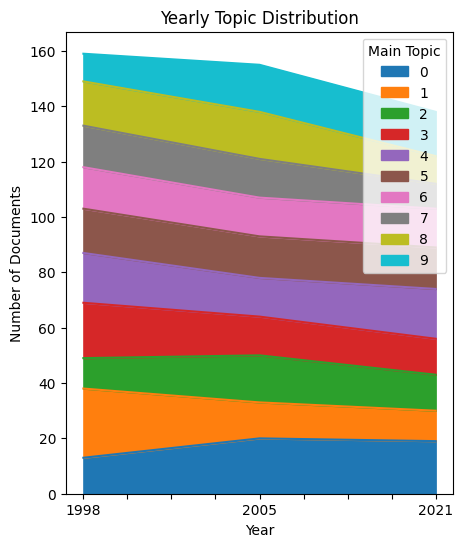

In [35]:
# 可視化
#topic_distribution_by_year.plot(kind='bar', stacked=True, figsize=(10, 6))
topic_distribution_by_year.plot(kind='area', stacked=True, figsize=(5, 6))
plt.title('Yearly Topic Distribution')
plt.xlabel('Year')
plt.ylabel('Number of Documents')
plt.legend(title='Main Topic')
plt.show()


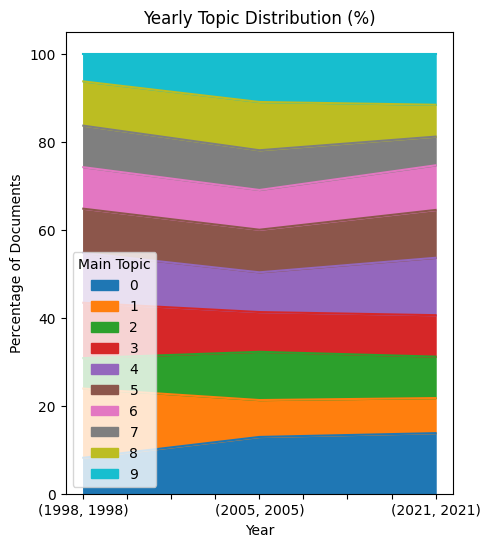

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Assuming 'df' is your DataFrame and it already includes 'year', 'main_topic', and 'topic_prob' columns

# 1. 各ドキュメントの主要トピックとその確率を識別
# This part remains the same as in your original script

# 2. 年別に主要トピックの分布を集計（パーセンテージで）
topic_count_by_year = df.groupby(['year', 'main_topic']).size()
topic_percentage_by_year = topic_count_by_year.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

# Convert Series to DataFrame for easier plotting
topic_percentage_by_year_df = topic_percentage_by_year.unstack(fill_value=0)

# 可視化
#topic_percentage_by_year_df.plot(kind='bar', stacked=True, figsize=(10, 6))
topic_percentage_by_year_df.plot(kind='area', stacked=True, figsize=(5, 6))

plt.title('Yearly Topic Distribution (%)')
plt.xlabel('Year')
plt.ylabel('Percentage of Documents')
plt.legend(title='Main Topic')
plt.show()

# 3. トピックごとの最も重要な単語とその重要度（確率）を表示するスクリプト
# This part remains the same as in your original script

# 4. LDAモデルの可視化（pyLDAvis）
# Also, remains unchanged

# 5. 企業ごとの主要トピック分布を集計し、可視化する
# As you have it in your script, this section would remain unchanged as well.


Yearly Topic Distribution (Count):
main_topic   0   1   2   3   4   5   6   7   8   9
year                                              
1998        13  25  11  20  18  16  15  15  16  10
2005        20  13  17  14  14  15  14  14  17  17
2021        19  11  13  13  18  15  14   9  10  16


Yearly Topic Distribution (Percentage):
main_topic          0          1          2          3          4          5  \
year year                                                                      
1998 1998    8.176101  15.723270   6.918239  12.578616  11.320755  10.062893   
2005 2005   12.903226   8.387097  10.967742   9.032258   9.032258   9.677419   
2021 2021   13.768116   7.971014   9.420290   9.420290  13.043478  10.869565   

main_topic          6         7          8          9  
year year                                              
1998 1998    9.433962  9.433962  10.062893   6.289308  
2005 2005    9.032258  9.032258  10.967742  10.967742  
2021 2021   10.144928  6.521739   7.246377 

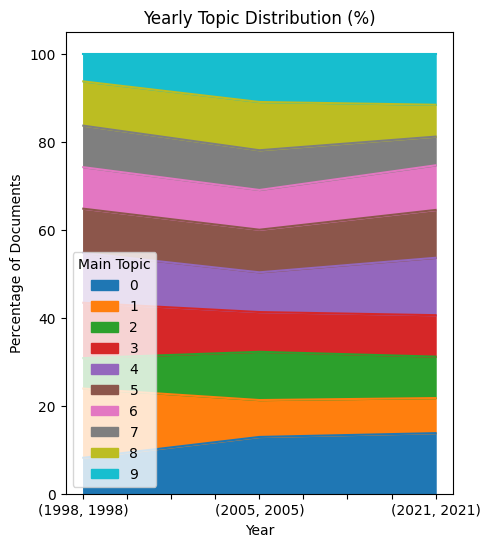

In [37]:
# 年別に主要トピックの分布を集計（数値で）
topic_count_by_year = df.groupby(['year', 'main_topic']).size().unstack(fill_value=0)
print("Yearly Topic Distribution (Count):")
print(topic_count_by_year)
print("\n")

# 年別に主要トピックの分布を集計（パーセンテージで）
topic_percentage_by_year_df = topic_percentage_by_year.unstack(fill_value=0)
print("Yearly Topic Distribution (Percentage):")
print(topic_percentage_by_year_df)
print("\n")

# 可視化（パーセンテージで）
#topic_percentage_by_year_df.plot(kind='bar', stacked=True, figsize=(10, 6))
topic_percentage_by_year_df.plot(kind='area', stacked=True, figsize=(5, 6))
plt.title('Yearly Topic Distribution (%)')
plt.xlabel('Year')
plt.ylabel('Percentage of Documents')
plt.legend(title='Main Topic')
plt.show()


In [38]:
# トピックごとの最も重要な単語とその重要度（確率）を表示するスクリプト
num_words = 10  # 各トピックから表示する単語の数

for topic_id in range(n_topics):
    # トピックIDとその単語と重要度（確率）を取得
    topic_words = d_lda.show_topic(topic_id, topn=num_words)
    
    print(f"Topic {topic_id}:")
    for word, prob in topic_words:
        print(f"    {word}: {prob:.4f}")  # 単語とその重要度を表示
    print("\n")


Topic 0:
    development: 0.0082
    pharmacy: 0.0075
    pharmaceutical: 0.0068
    build: 0.0066
    create: 0.0066
    manufacturing: 0.0061
    supply: 0.0059
    sales: 0.0059
    improve: 0.0058
    quality: 0.0056


Topic 1:
    such: 0.0066
    such as: 0.0065
    consumer: 0.0063
    500: 0.0053
    network: 0.0053
    providers: 0.0053
    deliver: 0.0053
    corporate: 0.0051
    superior: 0.0050
    best: 0.0049


Topic 2:
    provide: 0.0111
    individuals: 0.0082
    technology: 0.0080
    help: 0.0067
    provide … products: 0.0061
    about: 0.0061
    infrastructure: 0.0053
    million: 0.0042
    more … million: 0.0042
    than … million: 0.0042


Topic 3:
    return: 0.0091
    needs: 0.0072
    each: 0.0065
    investment: 0.0064
    -: 0.0061
    providing: 0.0057
    investors: 0.0049
    structure: 0.0049
    also: 0.0048
    provides: 0.0047


Topic 4:
    million: 0.0080
    retirement: 0.0072
    innovative: 0.0059
    vision: 0.0058
    highest: 0.0058
    w

main_topic  0  1  2  3  4  5  6  7  8  9
company                                 
AE          3  2  4  3  1  1  3  5  2  2
AIG         1  1  0  0  0  1  1  0  0  1
AS          6  4  1  4  4  3  1  3  1  0
BB          2  3  0  0  1  2  2  0  0  1
CC          6  1  2  5  1  1  1  0  2  4
CC2         1  0  0  1  1  1  1  0  2  2
CCM         1  2  5  0  2  0  3  1  0  3
CH          2  1  3  3  4  2  2  2  2  3
CN          2  0  3  0  4  1  3  3  0  1
CS          1  4  0  1  1  1  0  2  0  2
CV          1  1  0  1  1  1  4  1  0  0
CVS         2  3  1  1  1  1  1  0  1  3
DC          9  0  8  2  8  7  2  2  2  1
DC2         0  1  0  1  1  1  0  0  0  1
FM          0  3  1  0  1  2  0  1  3  0
MC          1  1  0  2  0  0  2  0  0  0
MK          4  4  2  1  2  3  5  0  1  2
MM          1  2  1  0  2  0  1  1  1  4
MM2         0  0  1  1  0  0  0  0  0  1
NLI         0  2  4  4  2  6  1  2  7  0
OC          2  0  1  1  2  2  0  0  3  0
PZ          3  3  0  1  3  3  2  4  4  0
TD          1  2

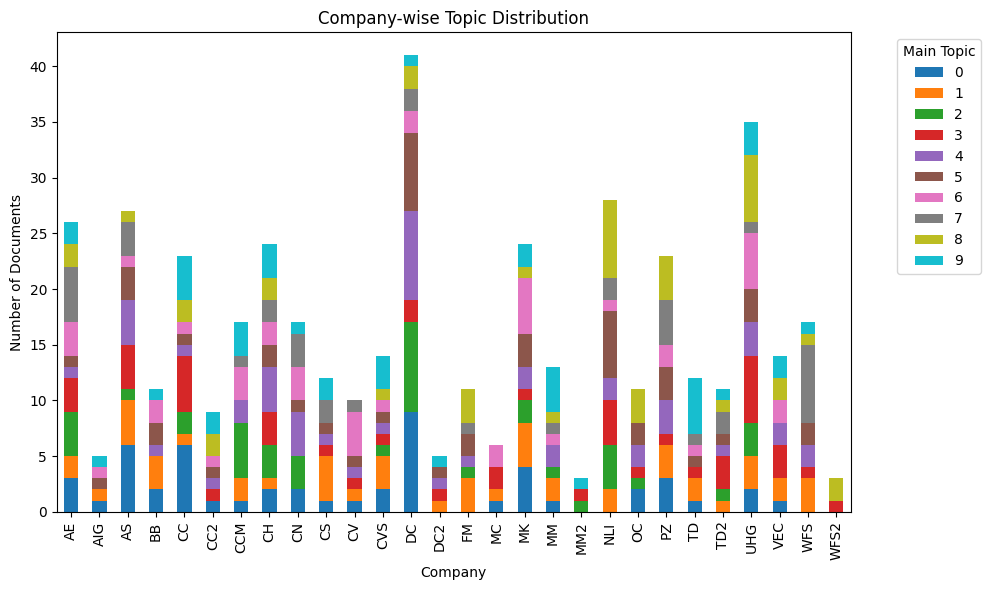

In [39]:
# 事前に定義されたDataFrame 'df' から、企業ごとの主要トピック分布を集計します。
topic_distribution_by_company = df.groupby(['company', 'main_topic']).size().unstack(fill_value=0)

# 集計結果を表示します。
print(topic_distribution_by_company)

# 結果を可視化する（オプション）
topic_distribution_by_company.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Company-wise Topic Distribution')
plt.xlabel('Company')
plt.ylabel('Number of Documents')
plt.legend(title='Main Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [40]:
#トピックの偏在: 企業ごとに、特定のトピックに関する文書の数に大きな偏りがあることが見て取れます。例えば、ある企業はトピック0に多くの文書を持ちながら、他のトピックでは少ない、というパターンです。これは企業が特定のテーマに焦点を当てているか、またはその期間中に特定のトピックが特に関連性が高かったことを示しています。

#多様な関心のあらわれ: いくつかの企業では、複数のトピックにわたって文書が分布しており、これはその企業が多様な分野に関心を持っていることを示しています。例えば、DCやUHGのような企業は、複数のトピックにわたって高い文書数を持っており、これらの企業は広範囲のテーマに取り組んでいる可能性があります。

#特定トピックの重視: 一方で、WMやWFS2のように、特定のトピックにのみ集中している企業もあります。これは、その企業が特定のテーマに特化しているか、あるいは特定の時期にそのトピックが特に重要であったことを示唆しています。

#時間的変化の検討: このデータでは年ごとの分布は示されていませんが、企業ごとのトピック分布を時間軸で比較することで、特定のトピックがどのように変化していくかを観察することができます。これにより、市場のトレンドや企業戦略の変化を推測することが可能です。

#競合分析の観点: 似たような業界の企業がどのトピックに焦点を当てているかを比較することで、競合分析の観点からも有益な情報が得られます。業界内で特定のトピックが際立って重視されている場合、それは業界全体の動向や関心のシフトを反映している可能性があります。

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74225/609705325.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['main_topic'] = [sorted(doc, key=lambda x: x[1], reverse=True)[0][0] for doc in d_lda.get_document_topics(corpus)]
/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74225/609705325.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_prob'] = [sorted(doc, key=lambda x: x[1], reverse=True)[0][1] for doc in d_lda.get_document_topics(corpus)]


main_topic   0   1   2   3   4   5   6   7   8   9
year                                              
1998        13  23  12  20  19  17  15  14  16  10
2005        21  13  16  14  14  15  14  14  17  17
2021        19  11  13  13  18  15  14   8  10  17


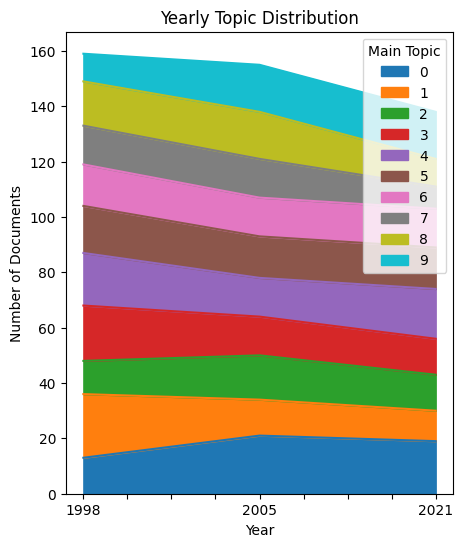

Topic 0:
    development: 0.0082
    pharmacy: 0.0075
    pharmaceutical: 0.0068
    build: 0.0066
    create: 0.0066
    manufacturing: 0.0061
    supply: 0.0059
    sales: 0.0059
    improve: 0.0058
    quality: 0.0056


Topic 1:
    such: 0.0066
    such as: 0.0065
    consumer: 0.0063
    500: 0.0053
    network: 0.0053
    providers: 0.0053
    deliver: 0.0053
    corporate: 0.0051
    superior: 0.0050
    best: 0.0049


Topic 2:
    provide: 0.0111
    individuals: 0.0082
    technology: 0.0080
    help: 0.0067
    provide … products: 0.0061
    about: 0.0061
    infrastructure: 0.0053
    million: 0.0042
    more … million: 0.0042
    than … million: 0.0042


Topic 3:
    return: 0.0091
    needs: 0.0072
    each: 0.0065
    investment: 0.0064
    -: 0.0061
    providing: 0.0057
    investors: 0.0049
    structure: 0.0049
    also: 0.0048
    provides: 0.0047


Topic 4:
    million: 0.0080
    retirement: 0.0072
    innovative: 0.0059
    vision: 0.0058
    highest: 0.0058
    w

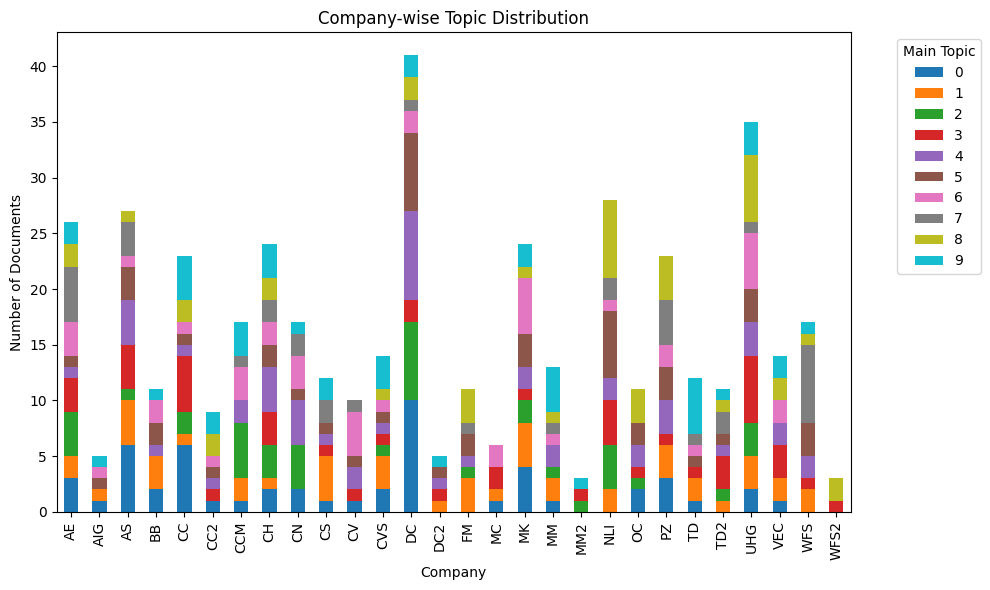

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# 1. 各ドキュメントの主要トピックとその確率を識別
df['main_topic'] = [sorted(doc, key=lambda x: x[1], reverse=True)[0][0] for doc in d_lda.get_document_topics(corpus)]
df['topic_prob'] = [sorted(doc, key=lambda x: x[1], reverse=True)[0][1] for doc in d_lda.get_document_topics(corpus)]

# 2. 年別に主要トピックの分布を集計
topic_distribution_by_year = df.groupby(['year', 'main_topic']).size().unstack(fill_value=0)
print(topic_distribution_by_year)

# 可視化
#topic_distribution_by_year.plot(kind='bar', stacked=True, figsize=(10, 6))
topic_distribution_by_year.plot(kind='area', stacked=True, figsize=(5, 6))
plt.title('Yearly Topic Distribution')
plt.xlabel('Year')
plt.ylabel('Number of Documents')
plt.legend(title='Main Topic')
plt.show()

# 3. トピックごとの最も重要な単語とその重要度（確率）を表示するスクリプト
num_words = 10  # 各トピックから表示する単語の数
for topic_id in range(n_topics):
    topic_words = d_lda.show_topic(topic_id, topn=num_words)
    print(f"Topic {topic_id}:")
    for word, prob in topic_words:
        print(f"    {word}: {prob:.4f}")
    print("\n")

# 4. LDAモデルの可視化（pyLDAvis）
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(d_lda, corpus, diction)
pyLDAvis.display(vis)

# 5. 企業ごとの主要トピック分布を集計し、可視化する
topic_distribution_by_company = df.groupby(['company', 'main_topic']).size().unstack(fill_value=0)
print(topic_distribution_by_company)
topic_distribution_by_company.plot(kind='bar', stacked=True, figsize=(10, 6))
#topic_distribution_by_company.plot(kind='area', stacked=True, figsize=(5, 6))

plt.title('Company-wise Topic Distribution')
plt.xlabel('Company')
plt.ylabel('Number of Documents')
plt.legend(title='Main Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

k-means でクラスタリング

In [42]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# 仮定：'company_topic_distribution'は企業とトピックの分布を持つDataFrameです。
# 以下のデータは例示用であり、実際のデータに置き換えてください。
company_data = {
    'company': ['AE', 'AIG', 'AS', 'BB', 'CC', 'CC2', 'CCM', 'CH', 'CN', 'CS', 'CV', 'CVS', 'DC', 'DC2', 'FM', 'MC', 'MK', 'MM', 'MM2', 'NLI', 'OC', 'PZ', 'TD', 'TD2', 'UHG', 'VEC', 'WFS', 'WFS2', 'WM'],
    '0': [3, 1, 9, 3, 3, 2, 1, 5, 2, 3, 0, 2, 9, 1, 3, 0, 7, 1, 1, 2, 1, 2, 1, 2, 8, 7, 0, 0, 0],
    '1': [6, 2, 2, 0, 1, 0, 1, 3, 3, 1, 2, 0, 4, 1, 0, 2, 3, 2, 0, 2, 3, 5, 2, 1, 3, 2, 3, 0, 0],
    # トピック2からトピック9までのデータも同様に追加
}

company_topic_distribution = pd.DataFrame(company_data)

# 企業名をインデックスに設定
company_topic_distribution.set_index('company', inplace=True)
#company_topic_distribution

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

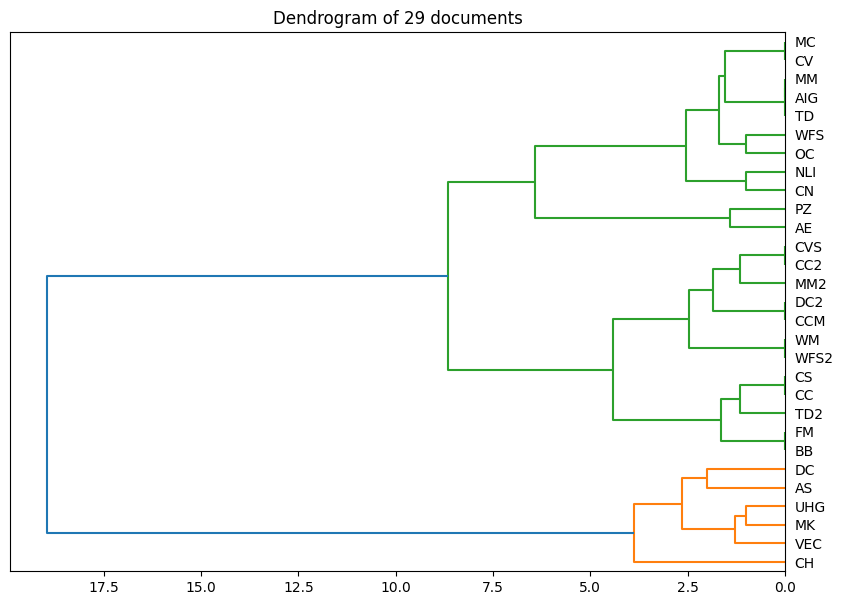

company
AE      2
AIG     2
AS      0
BB      1
CC      1
CC2     1
CCM     1
CH      0
CN      2
CS      1
CV      2
CVS     1
DC      0
DC2     1
FM      1
MC      2
MK      0
MM      2
MM2     1
NLI     2
OC      2
PZ      2
TD      2
TD2     1
UHG     0
VEC     0
WFS     2
WFS2    1
WM      1
Name: cluster, dtype: int32


In [43]:
# KMeansクラスタリング
n_clusters = 3  # 適宜調整する
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(company_topic_distribution)

# クラスタリング結果の追加
company_topic_distribution['cluster'] = kmeans.labels_

# 階層クラスタリングの樹形図
plt.figure(figsize=(10, 7))
linkage_matrix = linkage(company_topic_distribution.drop('cluster', axis=1), method='ward')
dendrogram(linkage_matrix, labels=company_topic_distribution.index.to_list(), orientation = 'left')
plt.title(f"Dendrogram of {len(company_topic_distribution)} documents")
plt.show()

# クラスタリング結果の確認
print(company_topic_distribution['cluster'])

In [44]:
# Cluster 0
# This cluster includes companies primarily from financial services, insurance, and pharmaceutical sectors. It seems to focus on companies that offer services or products directly related to financial security, health, and insurance. Examples include:

#American Express (AE): Financial services
#American International Group, Inc. (AIG): Insurance and financial services
#New York Life Insurance Company (NLI): Life insurance and financial services
#Pfizer Inc. (PZ): Pharmaceutical and biotechnology
#Oracle (OC): Technology, but with a significant emphasis on software solutions that could be heavily used in financial and health sectors.

#Cluster 1
#Cluster 1 appears to group companies involved in health services, energy, and certain types of retail or consumer services. These companies might share commonalities in providing essential services or products. Examples include:

#Charter Communications Inc. (CCM): Telecommunications, indicating a focus on service provision.
#Cardinal Health (CH): Healthcare services and products.
#UNITEDHEALTH GROUP (UHG): Healthcare services and insurance.
#Valero (VEC): Energy and petroleum, suggesting a broader interpretation of service and essential goods provision in this cluster.

#Cluster 2
#The companies in this cluster are more varied, including technology retail, consumer goods, automotive manufacturing, and more. This could indicate a cluster focused on manufacturing, retail, and consumer-oriented businesses. Examples include:

#Best Buy (BB), CVS Pharmacy (CVS), Costco Wholesale Corporation (CS): Retail-oriented companies with a significant physical and online presence.
#The Coca-Cola Company (CC), Ford Motor Company (FM): Manufacturing and consumer goods.

In [45]:
import pandas as pd

# クラスター情報を更新
cluster_info = pd.DataFrame({
    'company': ['AE', 'AIG', 'AS', 'BB', 'CC', 'CC2', 'CCM', 'CH', 'CN', 'CS', 'CV', 'CVS', 'DC', 'DC2', 'FM', 'MC', 'MK', 'MM', 'MM2', 'NLI', 'OC', 'PZ', 'TD', 'TD2', 'UHG', 'VEC', 'WFS', 'WFS2', 'WM'],
    'cluster': [0, 0, 1, 2, 2, 2, 2, 1, 0, 2, 0, 2, 1, 2, 2, 0, 1, 0, 2, 0, 0, 0, 0, 2, 1, 1, 0, 2, 2]
})

# 以下の既存のデータフレーム（df）にクラスター情報を結合するプロセスは、実際のdfの構造に依存します。
# 仮にdfが以下のような列を含むとします：'company', 'year', その他の必要な情報...

# df = pd.DataFrame({
#     'company': [...],  # 実際の企業名のリスト
#     'year': [...],     # 対応する年代のリスト
#     # その他の列...
# })

# クラスター情報を既存のデータフレーム（df）に追加
df_merged = pd.merge(df, cluster_info, on='company', how='left')

# 結果の表示
print(df_merged)


                                              sentence  text  \
0    Merck & Co., Inc., is a global, research-drive...     1   
1                                        NEW YORK LIFE     2   
2    and its subsidiaries comprise the fifth larges...     2   
3    In addition to life insurance and annuity prod...     2   
4    Through its subsidiary, New York Life Internat...     2   
..                                                 ...   ...   
447                         Keep our business growing?    74   
448                            Create loyal customers?    74   
449                         Deliver value and results?    74   
450         Prioritizing health at all stages of life.    75   
451                  Empowering generations of growth.    75   

                 source type company  year  n_words  \
0    Corporate profiles           MC  1998       40   
1    Corporate profiles          NLI  1998        3   
2    Corporate profiles          NLI  1998       17   
3    Corpor

<Figure size 1000x600 with 0 Axes>

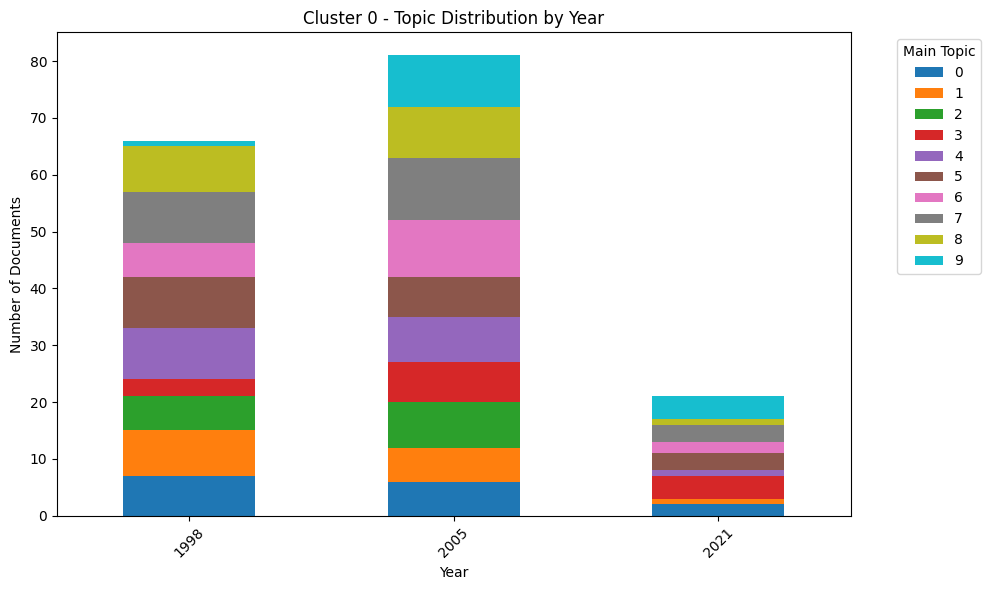

<Figure size 1000x600 with 0 Axes>

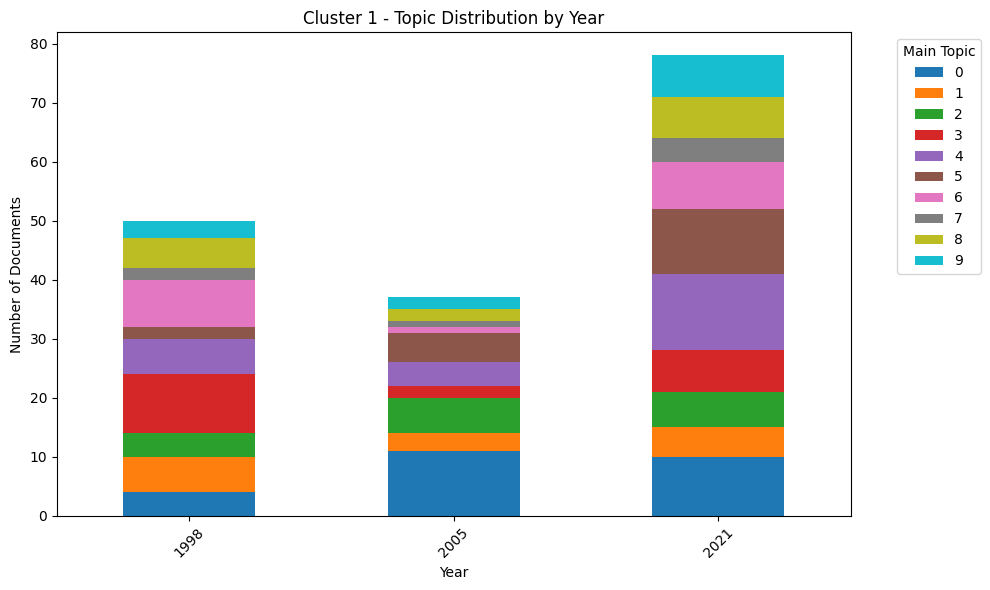

<Figure size 1000x600 with 0 Axes>

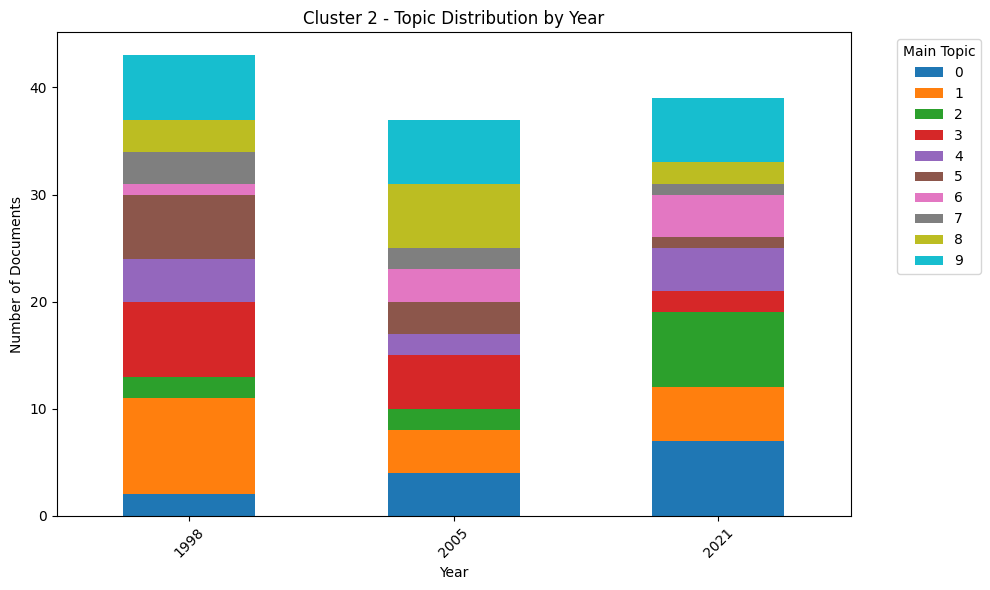

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# サンプルデータの集計
# groupby を使って 'cluster', 'year', 'main_topic' ごとに集計
grouped = df_merged.groupby(['cluster', 'year', 'main_topic']).size().reset_index(name='document_count')

# クラスターの数だけループして、クラスターごとにプロット
for cluster in sorted(grouped['cluster'].unique()):
    plt.figure(figsize=(10, 6))
    
    cluster_group = grouped[grouped['cluster'] == cluster]
    pivot_table = cluster_group.pivot_table(index='year', columns='main_topic', values='document_count', fill_value=0)
    
    pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))
    
    plt.title(f'Cluster {cluster} - Topic Distribution by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Documents')
    plt.legend(title='Main Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


<Figure size 1000x600 with 0 Axes>

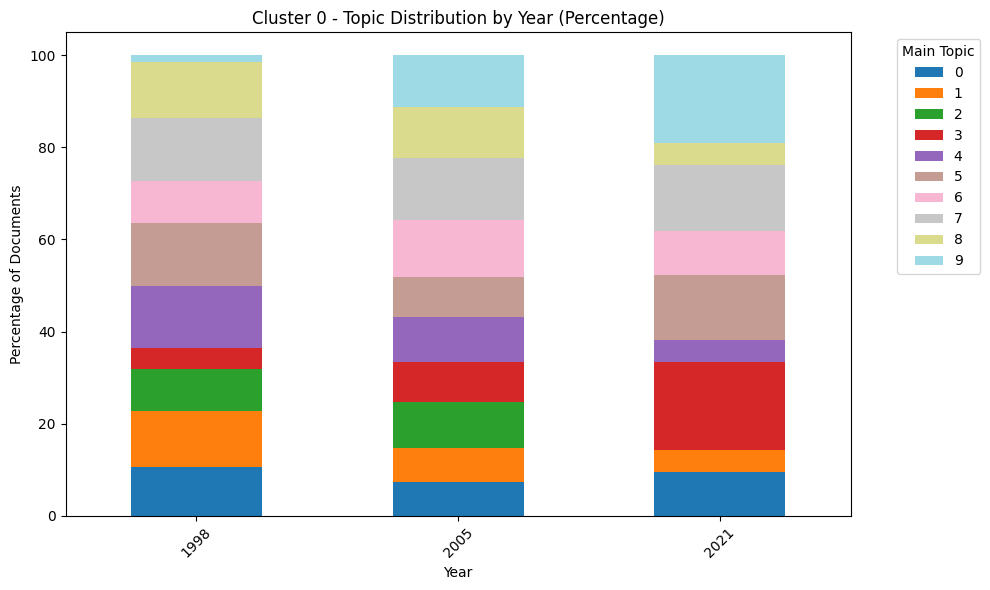

<Figure size 1000x600 with 0 Axes>

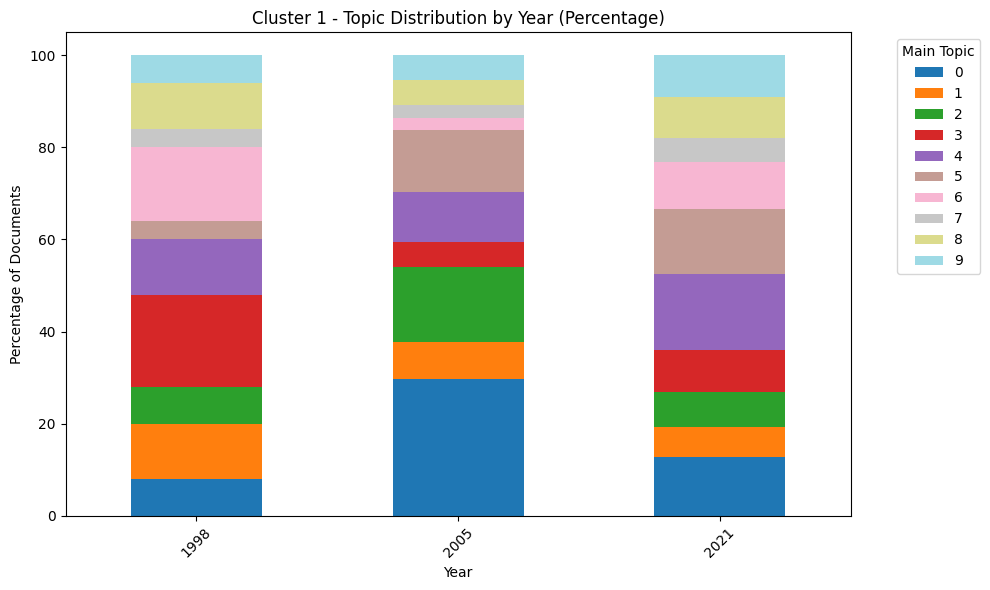

<Figure size 1000x600 with 0 Axes>

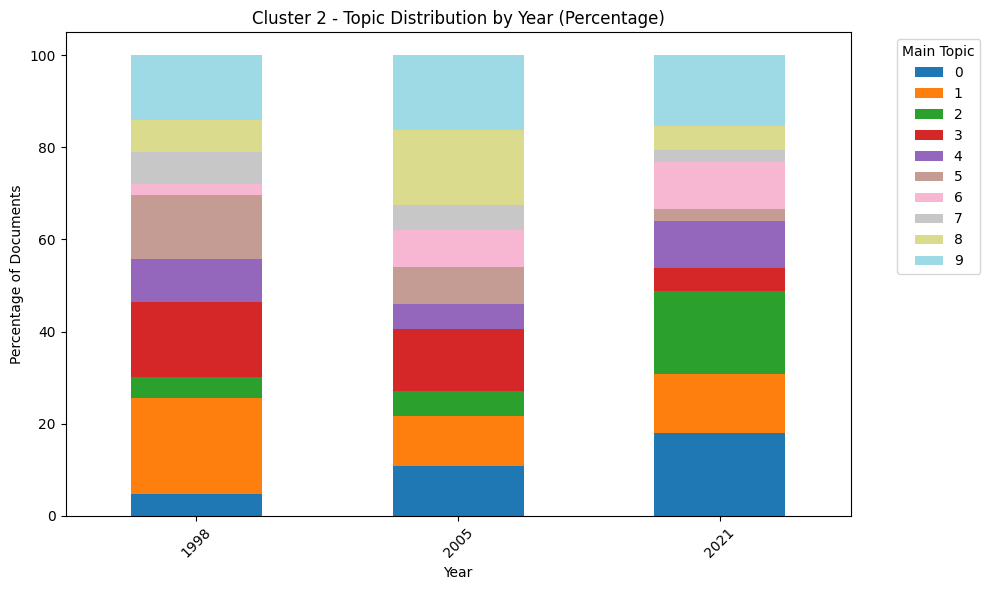

In [47]:
#それぞれの年代を100%にしてみた場合
import pandas as pd
import matplotlib.pyplot as plt

# サンプルデータの集計
# groupby を使って 'cluster', 'year', 'main_topic' ごとに集計
grouped = df_merged.groupby(['cluster', 'year', 'main_topic']).size().reset_index(name='document_count')

# クラスターの数だけループして、クラスターごとにプロット
for cluster in sorted(grouped['cluster'].unique()):
    plt.figure(figsize=(10, 6))
    
    cluster_group = grouped[grouped['cluster'] == cluster]
    pivot_table = cluster_group.pivot_table(index='year', columns='main_topic', values='document_count', fill_value=0)
    
    # トピックの割合を計算する
    pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100
    
    pivot_table_percentage.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
    
    plt.title(f'Cluster {cluster} - Topic Distribution by Year (Percentage)')
    plt.xlabel('Year')
    plt.ylabel('Percentage of Documents')
    plt.legend(title='Main Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [48]:
#!pip install -U WordCloud

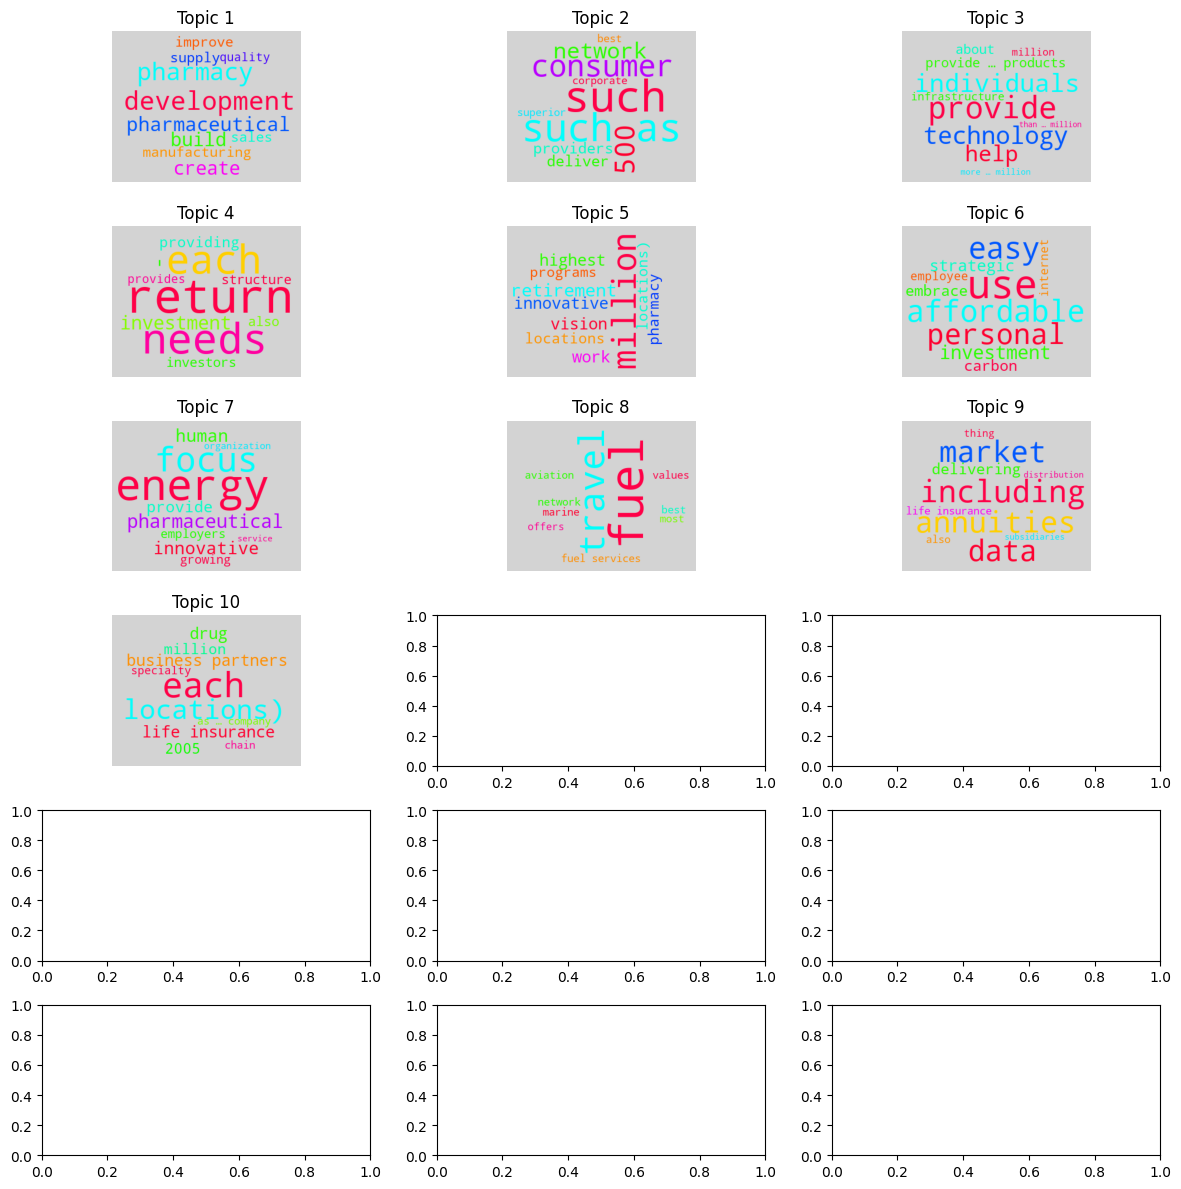

In [49]:
%%capture --no-display

## WordCloud を使ったD のLDA 結果の可視化

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud

## number of acceptable targets: 30[panes] = 5[cols] x 6[rows] 
fig, axs = plt.subplots(ncols = 3, nrows = 6, figsize = (12, 12))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

mask = np.array(Image.open("figures/shape-wc-mask-oval.png"))
for i, topic in enumerate(range(d_lda.num_topics)):
    x = dict(d_lda.show_topic(topic, n_topics))
    im = WordCloud(
        #font_path=font_path,
        background_color = 'lightgrey', colormap = "hsv",
        mask = mask, random_state = 0
    ).generate_from_frequencies(x)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('Topic ' + str(topic + 1))

## output
plt.tight_layout()
plt.show()

In [50]:
## LDA が生成した topics の階層クラスタリング

## 得られたtopics を確認
topic_enc = d_lda.get_topics()
topic_enc

array([[0.00044753, 0.00045974, 0.00040436, ..., 0.00021162, 0.00021162,
        0.00021162],
       [0.00017252, 0.00017252, 0.00017252, ..., 0.00017252, 0.00017252,
        0.00017252],
       [0.00019775, 0.00019775, 0.00019775, ..., 0.00019775, 0.00019775,
        0.00019775],
       ...,
       [0.00047967, 0.00043998, 0.00038651, ..., 0.00019343, 0.00019343,
        0.00019343],
       [0.00070329, 0.00073462, 0.00077568, ..., 0.00013068, 0.00054312,
        0.0005439 ],
       [0.00017053, 0.00017053, 0.00017053, ..., 0.00017053, 0.00017053,
        0.00017053]], dtype=float32)

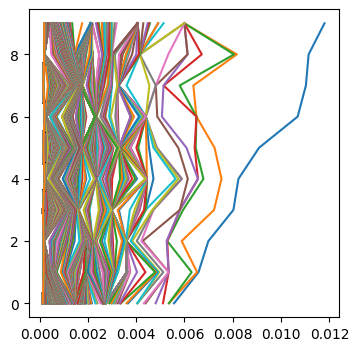

In [51]:
## topics エンコードの値の分布の検査

topic_enc_sorted = sorted([ sorted(enc, reverse = True) for enc in topic_enc ])

plt.figure(figsize = (4, 4))
plt.plot(topic_enc_sorted, range(0, len(topic_enc_sorted)))

plt.show()

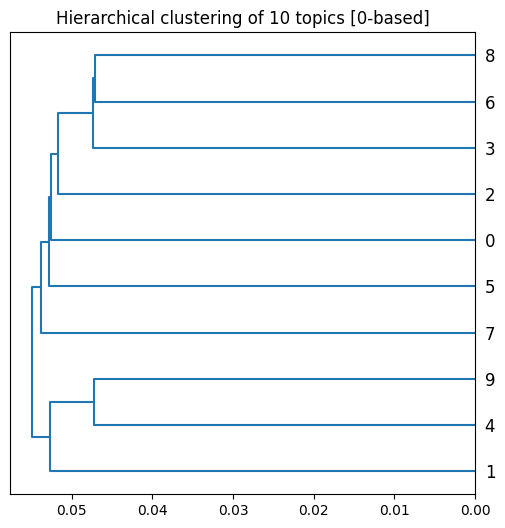

In [70]:
## topics の階層クラスタリング

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

## 作図範囲の指定
plt.figure(figsize = (6, 6))

## 距離行列の生成
topic_linkage = linkage(topic_enc, method = 'ward', metric = 'euclidean')
dendrogram(topic_linkage, orientation = 'left')

## 作図
plt.title(f"Hierarchical clustering of {n_topics} topics [0-based]")
plt.show()

Documents のクラスタリング

In [53]:
## 構築した LDA モデルを使って文(書)を分類する

bots = df[term_type] # df[doc_type] ではない
doc_encs = [ d_lda.get_document_topics(diction.doc2bow(bot),
                                     minimum_probability = 0) for bot in bots ]
#
doc_encs[:1]

[[(0, 0.00012486192),
  (1, 0.00012486192),
  (2, 0.00012486192),
  (3, 0.00012486192),
  (4, 0.00012486192),
  (5, 0.00012486192),
  (6, 0.9988763),
  (7, 0.00012486192),
  (8, 0.00012486192),
  (9, 0.00012486192)]]

In [54]:
## enc 列の追加
df['enc'] = [ [ x[-1] for x in doc_enc ] for doc_enc in doc_encs ] # This is the trick!
df

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74225/4256189122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['enc'] = [ [ x[-1] for x in doc_enc ] for doc_enc in doc_encs ] # This is the trick!


,sentence,text,source,type,company,year,n_words,1gram,2gram,skippy2gram,skippy3gram,main_topic,topic_prob,enc
1,"Merck & Co., Inc., is a global, research-drive...",1,Corporate profiles,,MC,1998,40,"[merck, co, global, research-driven, pharmaceu...","[merck co, co global, global research-driven, ...","[merck co, merck … global, merck … research-dr...","[merck co global, merck co … research-driven, ...",6,0.998876,"[0.00012486192, 0.00012486192, 0.00012486192, ..."
0,NEW YORK LIFE,2,Corporate profiles,,NLI,1998,3,"[new, york, life]","[new york, york life]","[new york, new … life, york life, new, york, l...","[new york life, new york, new … life, york lif...",5,0.978048,"[0.002439117, 0.002439117, 0.002439117, 0.0024..."
1,and its subsidiaries comprise the fifth larges...,2,Corporate profiles,,NLI,1998,17,"[subsidiaries, comprise, fifth, largest, life,...","[subsidiaries comprise, comprise fifth, fifth ...","[subsidiaries comprise, subsidiaries … fifth, ...","[subsidiaries comprise fifth, subsidiaries com...",8,0.991088,"[0.0009901909, 0.0009901909, 0.0009901909, 0.0..."
2,In addition to life insurance and annuity prod...,2,Corporate profiles,,NLI,1998,40,"[addition, life, insurance, annuity, products,...","[addition life, life insurance, insurance annu...","[addition life, addition … insurance, addition...","[addition life insurance, addition life … annu...",1,0.997698,"[0.00025579703, 0.99769783, 0.00025579703, 0.0..."
3,"Through its subsidiary, New York Life Internat...",2,Corporate profiles,,NLI,1998,19,"[through, subsidiary, new, york, life, interna...","[through subsidiary, subsidiary new, new york,...","[through subsidiary, through … new, through … ...","[through subsidiary new, through subsidiary … ...",5,0.995287,"[0.0005236122, 0.0005236122, 0.0005236122, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,Keep our business growing?,74,Corporate profiles,,AS,2005,4,"[keep, business, growing]","[keep business, business growing]","[keep business, keep … growing, business growi...","[keep business growing, keep business, keep … ...",6,0.918179,"[0.009091186, 0.009091186, 0.009091186, 0.0090..."
5,Create loyal customers?,74,Corporate profiles,,AS,2005,3,"[create, loyal, customers]","[create loyal, loyal customers]","[create loyal, create … customers, loyal custo...","[create loyal customers, create loyal, create ...",0,0.957141,"[0.95714056, 0.004762163, 0.004762163, 0.00476..."
7,Deliver value and results?,74,Corporate profiles,,AS,2005,4,"[deliver, value, results]","[deliver value, value results]","[deliver value, deliver … results, value resul...","[deliver value results, deliver value, deliver...",1,0.970965,"[0.0032260627, 0.97096545, 0.0032260627, 0.003..."
0,Prioritizing health at all stages of life.,75,Corporate profiles,,CN,2021,7,"[prioritizing, health, all, stages, life]","[prioritizing health, health all, all stages, ...","[prioritizing health, prioritizing … all, prio...","[prioritizing health all, prioritizing health ...",6,0.957138,"[0.0047624665, 0.0047624665, 0.0047624665, 0.0..."


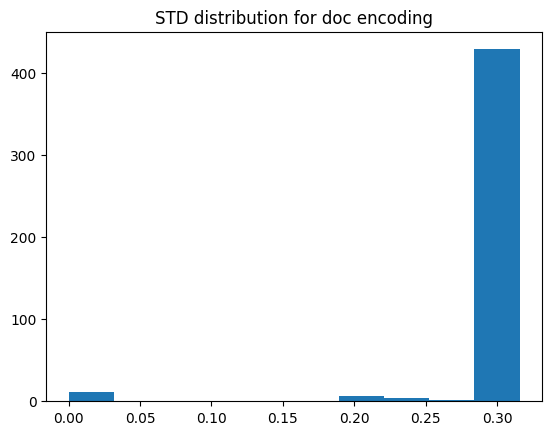

In [55]:
## エンコーディングのstd の分布を見る

from scipy.stats import tstd
from matplotlib import pyplot as plt

enc_std_dist = [ tstd(x) for x in df['enc'] ]
plt.hist(enc_std_dist)
plt.title(f"STD distribution for doc encoding")
plt.show()

In [56]:
## documents の階層クラスタリング
## 一様分布の事例を除外

check = False
print(f"{len(df)} instances before filtering")

E = np.array(list(df['enc']))
max_std = max([ np.std(x) for x in E])
if check: print(f"std max: {max_std}")

min_std = min([ np.std(x) for x in E])
if check: print(f"std min: {min_std}")

first_min_std = list(sorted(set([ np.std(x) for x in E])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ np.std(x) for x in E])))[-1]
print(f"std 2nd min: {second_min_std}")

452 instances before filtering
std 1st min: 0.0
std 2nd min: 0.2996300458908081


In [57]:
## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき

std_threshold = second_min_std / 4 # 穏健な値を得るために4で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#D_df_filtered = D_df[ D_df['encoding'] > std_threshold ]

## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
classified = [ False if np.std(x) < std_threshold else True for x in df['enc'] ]
df_filtered = df[ classified ]
#
print(f"{len(df_filtered)} instances remain after filtering ({len(df) - len(df_filtered)} instances removed)")

std_threshold: 0.07490751147270203
441 instances remain after filtering (11 instances removed)


In [58]:
## 事例のサンプリング

sampling = False
sampling_rate = 0.5 # 変更可能だが，大きくし過ぎると図が見にくい
if sampling:
    df_size = len(df_filtered)
    df_filtered = df_filtered.sample(round(df_size * sampling_rate))
    ##
    print(f"{len(df_filtered)} rows are sampled")

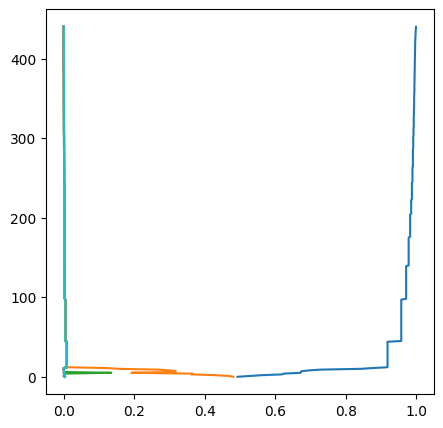

In [59]:
## doc エンコードの値の分布の検査

E_sorted = sorted([ sorted(enc, reverse = True) for enc in df_filtered['enc'] ])
plt.figure(figsize = (5, 5))
plt.plot(E_sorted, range(0, len(E_sorted)))
plt.show()

t-SNE 適用

In [60]:
## tSNE を使った documents のグループ化

from sklearn.manifold import TSNE

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
## perplexity は結合の強さを表わす指数で，値に拠って結果が代わるので，色々な値を試すと良い
if doc_perplexity_is_relative:
    doc_perplexity_val = round(len(df_filtered) * doc_perplexity_reduct_rate)
else:
    doc_perplexity_val = 30
print(f"doc_perplexity_val: {doc_perplexity_val}")
tSNE_3d = TSNE(n_components = 3, random_state = 0, perplexity = doc_perplexity_val, n_iter = 1000)

## データに適用
import numpy as np
E = np.array(list(df_filtered['enc']))
doc_tSNE_3d_fitted = tSNE_3d.fit_transform(E)

doc_perplexity_val: 22


In [61]:
#!pip install -U adjustText
#!pip install -U plotly

In [62]:
##
plot_df = pd.DataFrame(doc_tSNE_3d_fitted[:,0:3], columns = ['X', 'Y', 'Z'])
plot_df['text'] = list(map(str, df_filtered['text'])) # list(..) is crucial
plot_df[doc_type] = list(map(str, df_filtered[doc_type])) # list(..) is crucial
if verbose:
    plot_df

In [72]:
%%capture --no-display

## Plotlyを使って tSNE の結果の可視化 (3D)
import plotly.express as px

fig = px.scatter_3d(plot_df, x = 'X', y = 'Y', z = 'Z', color = 'text')
fig.update_traces(marker = dict(size = 5,
                              #line = dict(width = 2, color = 'DarkSlateGrey')
                               ),
                  selector = dict(mode = 'markers'))
title_val = f"t-SNE (perplexity: {doc_perplexity_val}) 3D clustering of {len(plot_df)} docs\nencoded by LDA (n_topics: {n_topics}; term: {term_size} {term_type})"
fig.update_layout(title = dict(text = title_val),
    autosize = False, width = 700, height = 700)
fig.show()

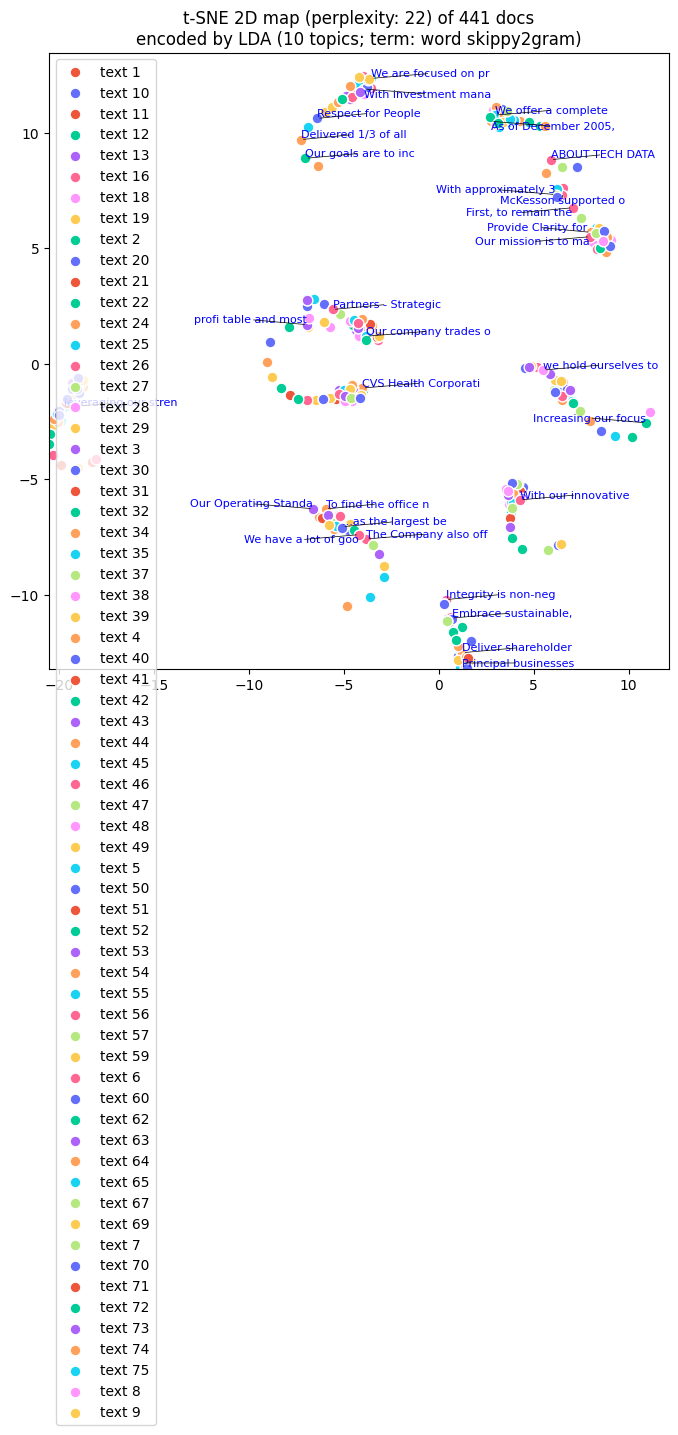

In [73]:
## tSNE 3D の結果を可視化

import matplotlib.pyplot as plt
from adjustText import adjust_text

## 描画サイズの指定
plt.figure(figsize = (8, 8))

## 図の大きさを決める
#fit_model = doc_tSNE_3d_fitted
X, Y, Z = plot_df['X'], plot_df['Y'], plot_df['Z'] 

plt.xlim(X.min(), X.max() + 1)
plt.ylim(Y.min(), Y.max() + 1)

## text で色分けする
#scatter = plt.scatter(X, Y, s = 40, c = 'r', edgecolors = 'w')
import plotly.express as ex
colormap = ex.colors.qualitative.Plotly
#cmap = list(map(lambda x: colormap[x], plot_df['text']))
#scatter = plt.scatter(X, Y, s = 60, c = cmap, edgecolors = 'w')
texts = [ ]
for val in np.unique(plot_df['text']):
    texts.append(f"text {val}")
    x = X[plot_df['text'] == val]
    y = Y[plot_df['text'] == val]
    plt.scatter(x, y, c=colormap[int(val) % len(colormap)], s=60, edgecolors='w')  # インデックスを範囲内に保つために % len(colormap) を追加


## 文字を表示する事例のサンプリング
used_keys = plot_df[doc_type]
lab_sample_n = 30
label_size = 20
sampled_keys = [ x[:label_size] for x in random.sample(list(used_keys), lab_sample_n) ]

## labels の生成
labels = [ ]
for x, y, s in zip(X, Y, sampled_keys):
    labels.append(plt.text(x, y, s, size = 8, color = 'blue'))

## label に repel を追加
adjust_text(labels,
            force_points = 0.2,
            force_text = 0.2,
            expand_points = (1, 1), expand_text = (1, 1),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

## 描画
plt.title(f"t-SNE 2D map (perplexity: {doc_perplexity_val}) of {len(X)} docs\nencoded by LDA ({n_topics} topics; term: {term_size} {term_type})")
plt.legend(texts)
plt.show()

In [74]:
## 事例のサンプリング

doc_sampling_rate = 0.3
doc_sample_n = round(len(df) * doc_sampling_rate)
if doc_sample_n < len(df):
    doc_sampling_rate = 1.0
    hc_df = df
else:
    hc_df = df.sample(doc_sample_n)
#
print(f"sampling_rate: {doc_sampling_rate}")

sampling_rate: 1.0


In [75]:
hc_df

,sentence,text,source,type,company,year,n_words,1gram,2gram,skippy2gram,skippy3gram,main_topic,topic_prob,enc,cluster
1,"Merck & Co., Inc., is a global, research-drive...",1,Corporate profiles,,MC,1998,40,"[merck, co, global, research-driven, pharmaceu...","[merck co, co global, global research-driven, ...","[merck co, merck … global, merck … research-dr...","[merck co global, merck co … research-driven, ...",6,0.998876,"[0.00012486192, 0.00012486192, 0.00012486192, ...",51
0,NEW YORK LIFE,2,Corporate profiles,,NLI,1998,3,"[new, york, life]","[new york, york life]","[new york, new … life, york life, new, york, l...","[new york life, new york, new … life, york lif...",5,0.978048,"[0.002439117, 0.002439117, 0.002439117, 0.0024...",44
1,and its subsidiaries comprise the fifth larges...,2,Corporate profiles,,NLI,1998,17,"[subsidiaries, comprise, fifth, largest, life,...","[subsidiaries comprise, comprise fifth, fifth ...","[subsidiaries comprise, subsidiaries … fifth, ...","[subsidiaries comprise fifth, subsidiaries com...",8,0.991088,"[0.0009901909, 0.0009901909, 0.0009901909, 0.0...",67
2,In addition to life insurance and annuity prod...,2,Corporate profiles,,NLI,1998,40,"[addition, life, insurance, annuity, products,...","[addition life, life insurance, insurance annu...","[addition life, addition … insurance, addition...","[addition life insurance, addition life … annu...",1,0.997698,"[0.00025579703, 0.99769783, 0.00025579703, 0.0...",15
3,"Through its subsidiary, New York Life Internat...",2,Corporate profiles,,NLI,1998,19,"[through, subsidiary, new, york, life, interna...","[through subsidiary, subsidiary new, new york,...","[through subsidiary, through … new, through … ...","[through subsidiary new, through subsidiary … ...",5,0.995287,"[0.0005236122, 0.0005236122, 0.0005236122, 0.0...",42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,Keep our business growing?,74,Corporate profiles,,AS,2005,4,"[keep, business, growing]","[keep business, business growing]","[keep business, keep … growing, business growi...","[keep business growing, keep business, keep … ...",6,0.918179,"[0.009091186, 0.009091186, 0.009091186, 0.0090...",54
5,Create loyal customers?,74,Corporate profiles,,AS,2005,3,"[create, loyal, customers]","[create loyal, loyal customers]","[create loyal, create … customers, loyal custo...","[create loyal customers, create loyal, create ...",0,0.957141,"[0.95714056, 0.004762163, 0.004762163, 0.00476...",85
7,Deliver value and results?,74,Corporate profiles,,AS,2005,4,"[deliver, value, results]","[deliver value, value results]","[deliver value, deliver … results, value resul...","[deliver value results, deliver value, deliver...",1,0.970965,"[0.0032260627, 0.97096545, 0.0032260627, 0.003...",19
0,Prioritizing health at all stages of life.,75,Corporate profiles,,CN,2021,7,"[prioritizing, health, all, stages, life]","[prioritizing health, health all, all stages, ...","[prioritizing health, prioritizing … all, prio...","[prioritizing health all, prioritizing health ...",6,0.957138,"[0.0047624665, 0.0047624665, 0.0047624665, 0.0...",52


/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from current font.

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 65293 (\N{FULLWIDTH HYPHEN-MINUS}) missing from current font.

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 9 (	) missing from current font.



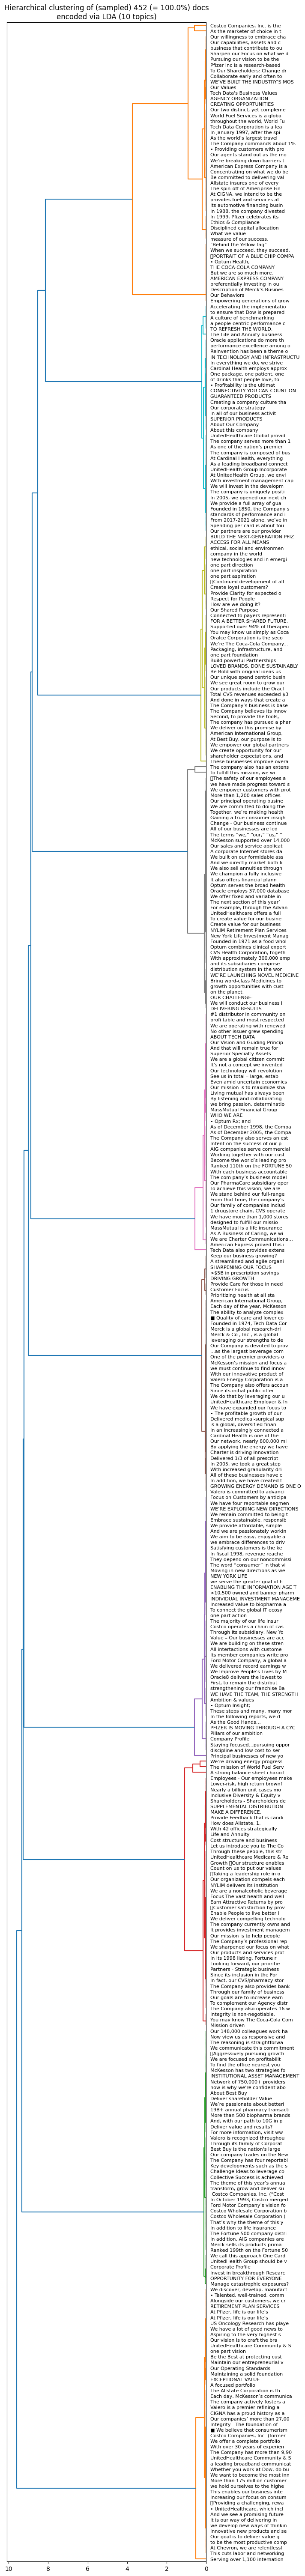

In [76]:
## doc 階層クラスタリングの実行

import numpy as np
import matplotlib.pyplot as plt
import plotly
#col_palette = plotly.colors.qualitative.Plotly
col_palette = plotly.colors.sequential.Viridis


use_japanese = False
if use_japanese:
    plt.rcParams["font.family"] = "Hiragino sans" # 日本語表示のための設定

from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成
doc_linkage = linkage(list(hc_df['enc']), method = 'ward', metric = 'euclidean')

## 描画サイズの指定
df_size = len(hc_df)
plt.figure(figsize = (6, round(df_size * 0.17))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_size = 30
label_vals = [ x[:label_size] for x in list(hc_df[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
dendrogram(doc_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

## 描画
plt.title(f"Hierarchical clustering of (sampled) {len(hc_df)} (= {100 * doc_sampling_rate}%) docs\nencoded via LDA ({n_topics} topics)")
plt.show()

クラスター毎に事例を列挙

In [77]:
## 階層クラスタリングから適当なクラスタリングを確定

import scipy.cluster as clusterer
threshold = 1.15 # 最良の値は探索して見つける
clustered = clusterer.hierarchy.fcluster(doc_linkage, threshold,
                           criterion = 'inconsistent', depth = 2, R = None, monocrit = None)
## 結果の確認: クラスターの数が適当である事を確認
np.unique(clustered)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115], dtype=int32)

In [78]:
## cluster 列を追加
hc_df['cluster'] = clustered
#
for cluster_id in set(hc_df['cluster']):
    print("=================")
    print(f"cluster_id: {cluster_id}")
    for i, row in hc_df[hc_df['cluster'] == cluster_id].iterrows():
        print(f"cluster {cluster_id}.{i}: {row[doc_type]}")

cluster_id: 1
cluster 1.0: to be the most productive company in the chemical industry
cluster 1.3: At Chevron, we are relentlessly focused on producing safe, reliable energy now and for the future.
cluster 1.2: Our goal is to deliver value growth and best-in-class performance.
cluster 1.5: This cuts labor and networking costs, while improving system performance and reliability.
cluster_id: 2
cluster 2.8: Innovative new products and services brought in 5.6 million new cards-in-force last year.
cluster 2.6: we develop new ways of thinking, operating and serving customers
cluster 2.5: It is our way of delivering innovation through collaboration, and it opens new opportunities for our employees, customers and shareholders.
cluster_id: 3
cluster 3.19: • UnitedHealthcare, which includes UnitedHealthcare Employer & Individual, UnitedHealthcare Medicare & Retirement,
cluster 3.2: Increasing our focus on consumers is now the basis of everything we do, and the foundation of the company’s vision 

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_74225/1308529646.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

